In [18]:
# Author: Umut Mehmet ERDEM - 2024

import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft 

"""
@brief Writes image data to a file in PGM format (P2 or P5).
@param1 magicnum: Magic number representing the PGM format (P2 for ASCII, P5 for binary).
@param2 filename: Path of the file to write the image data.
@param3 width: Width of the image.
@param4 height: Height of the image.
@param5 maxval: Maximum pixel value.
@param6 data: 2D list containing the image pixel data.
@retval None
"""
def mypgmwrite(magicnum, filename, width, height, maxval, data):
    with open(filename, 'wb') as f:
        f.write(f'{magicnum}\n#{filename}\n{width} {height}\n{maxval}\n'.encode())
        for row in data:
            for i in row: f.write(bytes([int(i)])) if magicnum == "P5" else f.write(f"{int(i)} ".encode())
            if magicnum == "P2": f.write('\n'.encode())

"""
@brief Reads image data from a PGM file (P2 or P5).
@param1 filename: Path of the file to read the image data from.
@retval magicnum: Magic number representing the PGM format (P2 for ASCII, P5 for binary).
@retval width: Width of the image.
@retval height: Height of the image.
@retval maxval: Maximum pixel value.
@retval data: 2D list containing the image pixel data.
"""
def mypgmread(filename):
    with open(filename, 'rb') as f:

        def read_and_cntrl():
            line = f.readline().strip()
            while line.startswith(b'#'):
                line = f.readline().strip()
            return line
        
        magicnum = read_and_cntrl()
        width, height = map(int, read_and_cntrl().split())
        maxval = int(read_and_cntrl())

        data = []
        if magicnum == b'P5':
            for i in range(height):
                data.append(list(f.read(width)))
        else:
            for i in range(height):
                data.append(list(map(int, read_and_cntrl().split())))

        print(f"{magicnum}\n{width} {height}\n{maxval}")
        for i in data: print(*i, sep=" ")
        return magicnum, width, height, maxval, data
    
"""
@brief Modifies the pixel values of a 2D list.
@param1 data: 2D list containing the image pixel data.
@param2 start_row: Starting row index.
@param3 end_row: Ending row index.
@param4 start_col: Starting column index.
@param5 end_col: Ending column index.
@param6 new_value: New pixel value.
@retval data: 2D list containing the modified image pixel data.
"""
def modify_pixels(data, start_row, end_row, start_col, end_col, new_value):
    for i in range(start_row, end_row + 1):
        for j in range(start_col, end_col + 1):
            data[i][j] = new_value
    return data

"""
@brief Creates the negative of an image by modifying the pixel values of a 2D list.
@param1 maxval: Maximum pixel value.
@param2 data: 2D list containing the image pixel data.
@retval f_negative: 2D list containing the negative image pixel data.
"""
def myImageNegative(maxval, data):
    f_negative = []
    for i in range(len(data)):
        f_negative.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_negative[i][j] = maxval - data[i][j]
    return f_negative

"""
@brief Normalizes the pixel values of a 2D list to the range [0, 255].
@param1 data: 2D list containing the image pixel data.
@retval normalized_data: 2D list containing the normalized image pixel data.
"""
def normalize(data):
    min_val, max_val = np.min(data), np.max(data)
    normalized_data = [[np.uint8((i-min_val)/(max_val-min_val)*255) for i in row] for row in data]
    return normalized_data

"""
@brief Applies logarithmic transformation to the given image data.
@param1 c: Constant value for the transformation.
@param2 data: 2D list containing the image pixel data.
@retval f_logTransformation: 2D list containing the transformed image pixel data.
"""
def myLogTransformation(c, data):
    f_logTransformation = []
    for i in range(len(data)):
        f_logTransformation.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_logTransformation[i][j] = c*np.log(1+data[i][j])
    
    f_logTransformation = normalize(f_logTransformation)
    return f_logTransformation

"""
@brief Applies gamma transformation to the given image data.
@param1 c: Constant value for the transformation.
@param2 gamma_val: Gamma value for the transformation.
@param3 data: 2D list containing the image pixel data.
@retval f_gammaTransformation: 2D list containing the transformed image pixel data.
"""
def myGammaTransformation(c, gamma_val, data):
    f_gammaTransformation = []
    for i in range(len(data)):
        f_gammaTransformation.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_gammaTransformation[i][j] = c*(data[i][j]**gamma_val)
    
    f_gammaTransformation = normalize(f_gammaTransformation)
    return f_gammaTransformation

"""
@brief Applies correlation operation on the given image data using the provided kernel.
@param1 kernel: 2D list containing the kernel values.
@param2 data: 2D list containing the image pixel data.
@param3 avarage: if set to 1, the kernel is averaged.
@param4 normalization: if set to 1, the resulting image is normalized.
@retval f_correlation: 2D list containing the correlated image pixel data.
"""
def myImageCorrelation(kernel, data, avarage=1, normalization=1):
    x_kernel, y_kernel = np.size(kernel, 0), np.size(kernel, 1)
    x_data, y_data = np.size(data, 0), np.size(data, 1)
    pad_size_x, pad_size_y = x_kernel // 2, y_kernel // 2
    pad_data = np.pad(data, ((pad_size_x, pad_size_x), (pad_size_y, pad_size_y)), mode='constant', constant_values=0)
    f_correlation = np.zeros_like(data, dtype=float)
    average = np.sum(np.abs(kernel)) if avarage else 1

    for i in range(x_data):
        for j in range(y_data):
            region = pad_data[i:i + x_kernel, j:j + y_kernel]
            f_correlation[i, j] = np.sum(region * kernel) / average
    if normalization: f_correlation = normalize(f_correlation)
    
    return f_correlation

"""
@brief Applies median filtering to the given image data.
@param1 kernel_size: Size of the kernel (must be an odd number).
@param2 data: 2D list or numpy array containing the image pixel data.
@retval f_median: 2D numpy array containing the filtered image pixel data.
"""
def myImageMedian(kernel_size, data):
    pad_size = kernel_size//2
    pad_data = np.pad(data, pad_size, mode='constant', constant_values=0)
    
    f_median = np.zeros_like(data)
    
    for i in range(len(data)):
        for j in range(len(data[i])):
            kernel = pad_data[i:i + kernel_size, j:j + kernel_size]
            f_median[i, j] = np.median(kernel)
    
    return f_median

"""
@brief Applies Laplacian filter to the given image data using the provided kernel.
@param1 kernel: 2D array containing the kernel values.
@param2 data: 2D array containing the image pixel data.
@param3 normalization: if set to 1, the resulting image is normalized.
@retval 2D array containing the Laplacian filtered image pixel data.
"""
def myImageLaplacian(kernel, data, normalization=0):
    if not normalization: return myImageCorrelation(kernel, data, 0, 0)
    else: return myImageCorrelation(kernel, data, 1, 1)

"""
@brief Applies sharpening filter to the given image data using the provided kernel.
@param1 kernel: 2D array containing the kernel values.
@param2 data: 2D array containing the image pixel data.
@retval f_sharpened: 2D array containing the sharpened image pixel data.
"""
def myImageSharpe(kernel, data):
    f_sharpened = myImageLaplacian(kernel, data, 0)
    return np.subtract(data, f_sharpened)

"""
@brief Creates a Gaussian kernel.
@param1 size: Size of the kernel (must be an odd number).
@param2 sigma: Standard deviation of the Gaussian distribution.
@retval kernel: 2D numpy array containing the Gaussian kernel values.
"""
def myGaussianKernel(size, sigma=1):
    center = size // 2
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = (1 / (2*np.pi * sigma**2)) * np.exp(-(x**2 + y*2) / (2 * sigma**2))
    return kernel

"""
@brief Applies Gaussian blur to the given image data using the provided kernel.
@param1 kernel: 2D list containing the Gaussian kernel values.
@param2 data: 2D list containing the image pixel data.
@retval f_gaussian_blurredData: 2D list containing the blurred image pixel data.
"""
def myImageGaussian(kernel, data):
    f_gaussian_blurredData = myImageCorrelation(kernel, data, 1, 0)
    return f_gaussian_blurredData

"""
@brief Applies histogram equalization to the given image data.
@param1 L: The maximum intensity value in the image.
@param2 data: 2D array containing the image pixel data.
@retval f_equalized: 2D array containing the histogram equalized image pixel data.
"""
def histogram_equalization(L, data):
    data = np.array(data)
    histogram, bins = np.histogram(data, bins=L, range=(0, L))
    normalized_histogram = histogram / data.size
    cumulative_histogram = np.cumsum(normalized_histogram)
    transformation_function = (L - 1) * cumulative_histogram
    f_equalized = transformation_function[data.ravel()].reshape(data.shape).astype(np.uint8)
    
    return bins, normalized_histogram, cumulative_histogram, f_equalized

"""
@brief  Computes the 2D Fast Fourier Transform (FFT) of the given 2D data array.
        This function first applies the 1D FFT to each row of the input data array,
        and then applies the 1D FFT to each column of the resulting array.
@param1 data: 2D array containing the image pixel data.
@retval fft_data: 2D array containing the FFT of the image pixel data.
"""
def my2Dfft(data):
    fft_rows = np.array([np.fft.fft(row) for row in data])
    fft_data = np.array([np.fft.fft(col) for col in fft_rows.T]).T
    return fft_data

"""
@brief  Computes the 2D Discrete Fourier Transform (DFT) of the given 2D array as Manual. The function computes the DFT using the formula:
        F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N)) where M and N are the dimensions of the input data.
@param1 data: A 2D array of shape (M, N) representing the image pixel data.
@retval dft_data: A 2D array of shape (M, N) containing the DFT of the image pixel data.
"""
def my2Dft(data):
    M, N = data.shape
    dft_data = np.zeros((M, N), dtype=complex)
    for k in range(M):
        for l in range(N):
            dft_data[k, l] = sum(data[m, n] * np.exp(-2j * np.pi * (k * m / M + l * n / N)) for m in range(M) for n in range(N))
    return dft_data

"""
@brief  Applies a centered 2D Fast Fourier Transform (FFT) to the image pixel data.
@param1 data: 2D array containing the image pixel data.
@retval centered_fft_data: The centered 2D FFT of the image pixel data.
"""
def my2DfftShift(data):
    centered_fft_data = np.zeros(np.shape(data))
    for x in range(len(data)):
        for y in range(len(data[0])):
            centered_fft_data[x][y] = data[x][y]*((-1)**(x+y))
    return centered_fft_data

"""
@brief  Computes the inverse 2D Fast Fourier Transform (FFT) of the given data.
        This function takes the 2D FFT data, computes its conjugate, applies the 
        2D FFT on the conjugated data, and then conjugates the result again. 
        Finally, it normalizes the result by dividing by the size of the input data.
        F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N))
        F'(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F*(u,v)e^(-j2π(ux/M + vy/N))
        MNf(x,y) = F'*(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F(u,v)e^(j2π(ux/M + vy/N))
@param1 fft_data: A 2D array containing the FFT-transformed data.
@retval ifft_data: The inverse 2D FFT of the image pixel data.
"""
def my2Difft(fft_data):
    conjugated_data = np.conjugate(fft_data)
    ifft_data = np.conjugate(my2Dfft(conjugated_data))/fft_data.size
    return ifft_data

In [19]:
magicnum, width, height, maxval, data = mypgmread("Fig0343(a).pgm")

b'P5'
500 800
255
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
def myImageSobel(kernel, data):
    f_sobel = myImageCorrelation(kernel, data, 0, 0)
    return f_sobel

### Time Domain

In [21]:
f_laplacian = np.array(myImageLaplacian([[1, 1, 1], [1, -8, 1], [1, 1, 1]], data, 1))

In [22]:
f_sharpened = np.array(myImageSharpe([[1, 1, 1], [1, -8, 1], [1, 1, 1]], data))

In [23]:
f_sobelGradient = np.abs(myImageSobel([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], data)) + np.abs(myImageSobel(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).T, data))

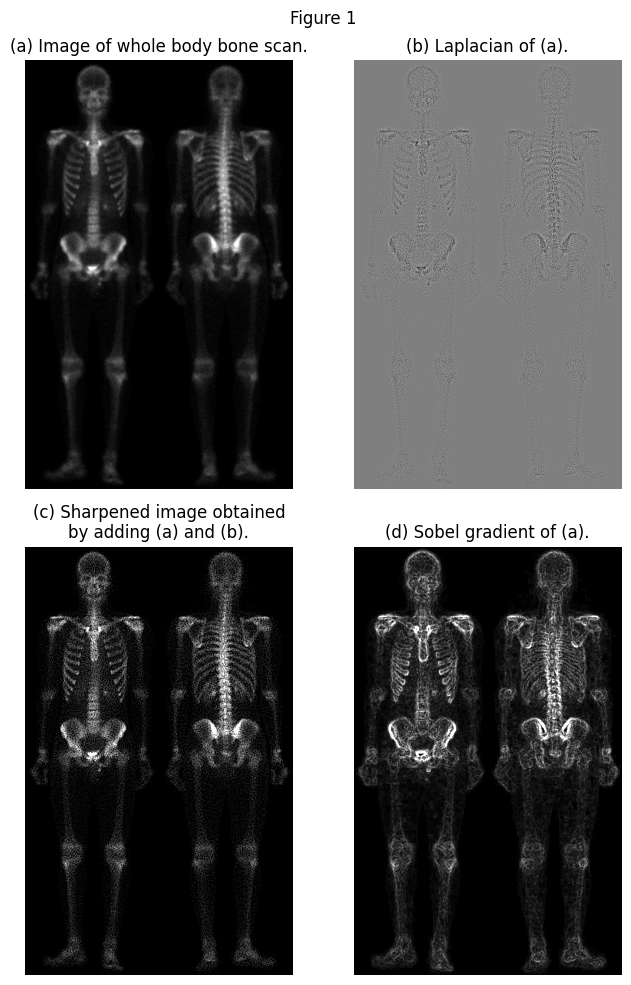

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(7, 10))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off")
ax[0, 0].imshow(data, cmap="gray", vmin=0, vmax=255), ax[0, 1].imshow(f_laplacian, cmap="gray", vmin=0, vmax=255)
ax[1, 0].imshow(f_sharpened, cmap="gray", vmin=0, vmax=255), ax[1, 1].imshow(f_sobelGradient, cmap="gray", vmin=0, vmax=255)
ax[0, 0].set_title("(a) Image of whole body bone scan."), ax[0, 1].set_title("(b) Laplacian of (a).")
ax[1, 0].set_title("(c) Sharpened image obtained\nby adding (a) and (b)."), ax[1, 1].set_title("(d) Sobel gradient of (a).")
fig.suptitle("Figure 1")
fig.tight_layout()
plt.show()

Görseller incelendiğinde, Figure1(b) şıkkındaki görselde [[1, 1, 1], [1, -8, 1], [1, 1, 1]] maskesinin görsel ile korelasyonu sonucunda ortaya çıkan laplacian görüntüsünün normalize edilmiş halidir. Figure1(c) şıkkındaki sharpened görüntüsünde laplacian görüntüsü eklenerek(maskenin ortası negatif değere sahip olduğundan çıkarma işlemi gerçekleştirilmiştir) oluşturulmuştur. Bu görüntü ile orijinal görüntü karşılaştırıldığında, görüntüdeki hatların keskinleştiği gözlemlenmiştir. Figure1(d) şıkkındaki Sobel Gradient uygulanan görüntüde x ve y ekseninde sobel filtreleri ile görüntüdeki kenar hatları tespit edilmiştir.

In [25]:
f_SobelBlured = np.array(myImageCorrelation(np.ones((5,5)), f_sobelGradient, 1, 0))
f_maskImage = normalize(f_SobelBlured*f_sharpened)
f_sharpenedImage = normalize(np.array(data)+f_maskImage)

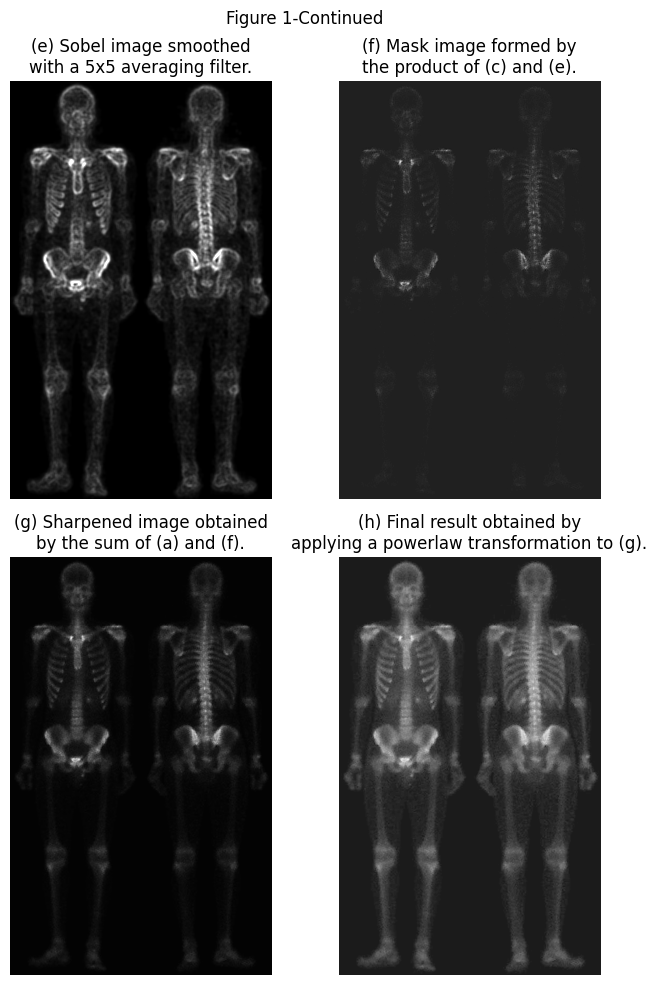

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(7, 10))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off")
ax[0, 0].imshow(f_SobelBlured, cmap="gray", vmin=0, vmax=255), ax[0, 1].imshow(f_maskImage, cmap="gray", vmin=0, vmax=255)
ax[1, 0].imshow(f_sharpenedImage, cmap="gray", vmin=0, vmax=255), ax[1, 1].imshow(myGammaTransformation(1, 0.5, f_sharpenedImage), cmap="gray", vmin=0, vmax=255)
ax[0, 0].set_title("(e) Sobel image smoothed\nwith a 5x5 averaging filter."), ax[0, 1].set_title("(f) Mask image formed by\nthe product of (c) and (e).")
ax[1, 0].set_title("(g) Sharpened image obtained\nby the sum of (a) and (f)."), ax[1, 1].set_title("(h) Final result obtained by\napplying a powerlaw transformation to (g).")
fig.suptitle("Figure 1-Continued")
fig.tight_layout()
plt.show()

Figure1(e)'deki görselde, Figure1(d)'deki sobel gradient'i uygulanan görüntü 5x5 ortalama filtresi ile bulanıklaştırılmıştır. Figure1(f)'de keskinleştirilmiş görsel ile bulanıklaştırılmış görsel çarpılmıştır. Burada, görseldeki dominant(optimum renk değeri) değere sahip alanlar beyaz renkte görülmektedir. Figure1(g)'deki görselde renk değerlerinin aralığı birbirine yakınlaşmasının yanı sıra görsel keskin hatlarını korumuştur. Figure1(h)'deki görsel, Figure1(g)'de orijinal ve maskelenmiş görsellerin toplanması ile gerçekleşen görüntünün gamma transformuna sokulması ve normalize edilmesi sonucunda elde edilmiştir. Burada görseldeki keskin hatlar korunmuş ayrıca pixel aralığı daraltılarak görünmeyen hatların görünmesi sağlanmıştır.

### Frequency Domain

In [27]:
"""
@brief  Maps the dimensions of two matrices to the same size by padding them with zeros.
        This function takes two matrices, converts them to numpy arrays, and pads them
        with zeros so that they have the same dimensions. The new dimensions are calculated
        as M1 + M2 - 1 and N1 + N2 - 1, where M1, N1 are the dimensions of the first matrix
        and M2, N2 are the dimensions of the second matrix.
@param1 matrix1: The first input matrix.
@param2 matrix2: The second input matrix.
@retval matrix1: The first matrix padded to the new dimensions.
@retval matrix2: The second matrix padded to the new dimensions.
"""
def myMatrixDimensionMapping(matrix1, matrix2):
    matrix1, matrix2 = np.array(matrix1), np.array(matrix2)
    M1, N1 = matrix1.shape
    M2, N2 = matrix2.shape
    M, N = M1 + M2 - 1, N1 + N2 - 1
    matrix1 = np.pad(matrix1, ((0, np.abs(M-M1)), (0, np.abs(N-N1))), mode='constant')
    matrix2 = np.pad(matrix2, ((0, np.abs(M-M2)), (0, np.abs(N-N2))), mode='constant')
    return matrix1, matrix2

"""
@brief  Applies a frequency filter to the input data using the given filter.
        This function takes an input matrix and a filter matrix, pads them to the same size,
        computes their 2D FFT, multiplies the FFT results element-wise, and then computes the
        inverse 2D FFT of the product. The result is cropped to the original size of the input matrix.
@param1 f: The input matrix to be filtered.
@param2 h: The filter matrix.
@retval g: The filtered result cropped to the original size of the input matrix.
@retval G: The product of the FFTs of the padded input and filter matrices.
@retval F: The FFT of the padded input matrix.
@retval H: The FFT of the padded filter matrix.
"""
def Freqfilter(f, h):
    f, h = np.array(f), np.array(h)
    f_padded, h_padded = myMatrixDimensionMapping(f, h)
    F, H = my2Dfft(my2DfftShift(f_padded)), my2Dfft(my2DfftShift(h_padded))
    G = F * H
    g = np.real(my2DfftShift(my2Difft(G)))
    return g[0:f.shape[0], 0:f.shape[1]], G, F, H

In [28]:
g, G, F, H = Freqfilter(data, [[1, 1, 1], [1, -8, 1], [1, 1, 1]])
g1 = np.subtract(data, g)
G1 = my2Dfft(my2DfftShift(g1))
g2_1, G2_1, F2_1, H2_1 = Freqfilter(data, [[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
g2_2, G2_2, F2_2, H2_2 = Freqfilter(data, np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).T)
g2 = np.abs(g2_1) + np.abs(g2_2)

C:\Users\umutu\AppData\Local\Temp\ipykernel_3012\28482002.py:269: ComplexWarning: Casting complex values to real discards the imaginary part
  centered_fft_data[x][y] = data[x][y]*((-1)**(x+y))


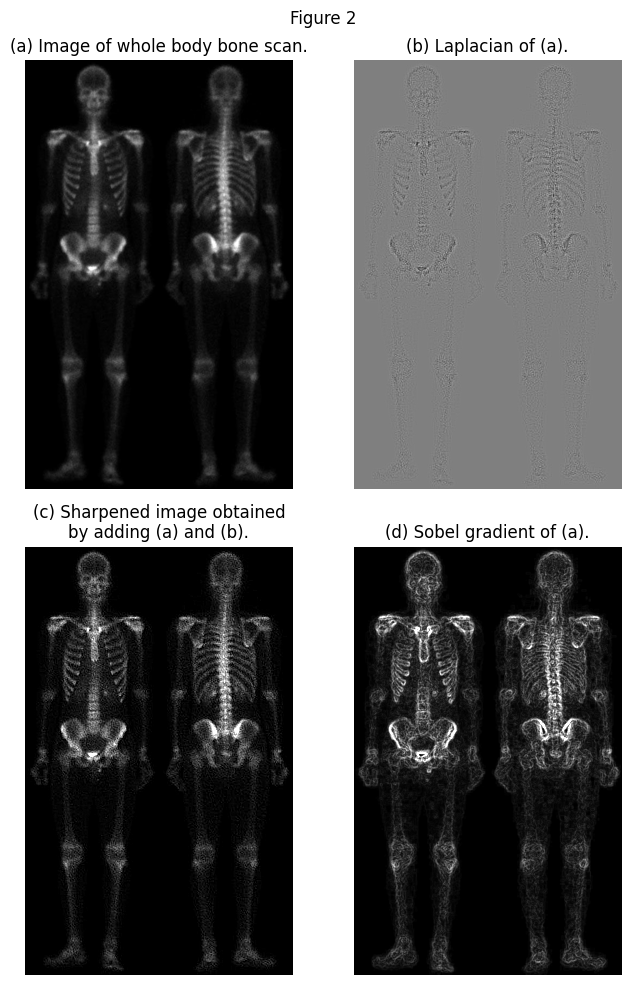

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(7, 10))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off")
ax[0, 0].imshow(data, cmap="gray", vmin=0, vmax=255), ax[0, 1].imshow(normalize(g), cmap="gray", vmin=0, vmax=255)
ax[1, 0].imshow(g1, cmap="gray", vmin=0, vmax=255), ax[1, 1].imshow(g2, cmap="gray", vmin=0, vmax=255)
ax[0, 0].set_title("(a) Image of whole body bone scan."), ax[0, 1].set_title("(b) Laplacian of (a).")
ax[1, 0].set_title("(c) Sharpened image obtained\nby adding (a) and (b)."), ax[1, 1].set_title("(d) Sobel gradient of (a).")
fig.suptitle("Figure 2")
fig.tight_layout()
plt.show()

Figure1'de zaman domaininde oluşturulan görüntüler, burada frekans domaininde gerçekleştirilmiştir. Bunun için görüntü ile uygulanacak filtrenin satır ve sütün boyutları alınmış ve bunlara zero padding yapılarak boyutlarının eşitlenmesi sağlanmıştır. Bunun için ikisinin de boyut bilgileri alınarak "A+B-1" formülüne göre yeni boyutları belirlenmiştir. "myMatrixDimensionMapping" fonksiyonu ile boyutları eşitlenen 2 matris için de "Freqfilter" fonksiyonu içerisinde öncelikle (-1)^(x+y) formülü ile frekans domaininde DC noktası merkeze taşınmış, sonrasında Fourier donüşümleri alınıp çarpılarak yeni oluşacak görüntünün Fourier dönüşümü elde edilmiştir. Sonrasında, ters Fourier dönüşümü alınıp DC noktası eski yerine taşınmış ve görüntüdeki imajiner ifadelerden kurtulunarak yeni görüntü bulunmuştur. Ayrıca, yeni oluşan görüntüdeki zero padding ile eklenen bölgeler atılmıştır. Figure2(b)'deki görüntü, orijinal görüntü ile laplacian maskesinin "Freqfilter" fonksiyonu ile frekans domaininde işlenmesi sonucunda elde edilmiş ve zaman domainindeki görsel ile benzer olduğu gözlemlenmiştir. Benzer işlemler Figure2(c) ve (d) şıklarında da gerçekleştirilmiştir. Figure2(d) şıkkında Sobel gradient'i için x ve y ekseninde bulunan sobel ile kenar tespiti yapılan iki görsel mutlaklarının toplamı alınarak bulunmuştur.

In [30]:
g3, G3, F3, H3 = Freqfilter(g2, np.ones((5,5))/25)

C:\Users\umutu\AppData\Local\Temp\ipykernel_3012\28482002.py:269: ComplexWarning: Casting complex values to real discards the imaginary part
  centered_fft_data[x][y] = data[x][y]*((-1)**(x+y))


In [31]:
g4 = normalize(g3*g1)
g5 = normalize(np.array(data)+g4)

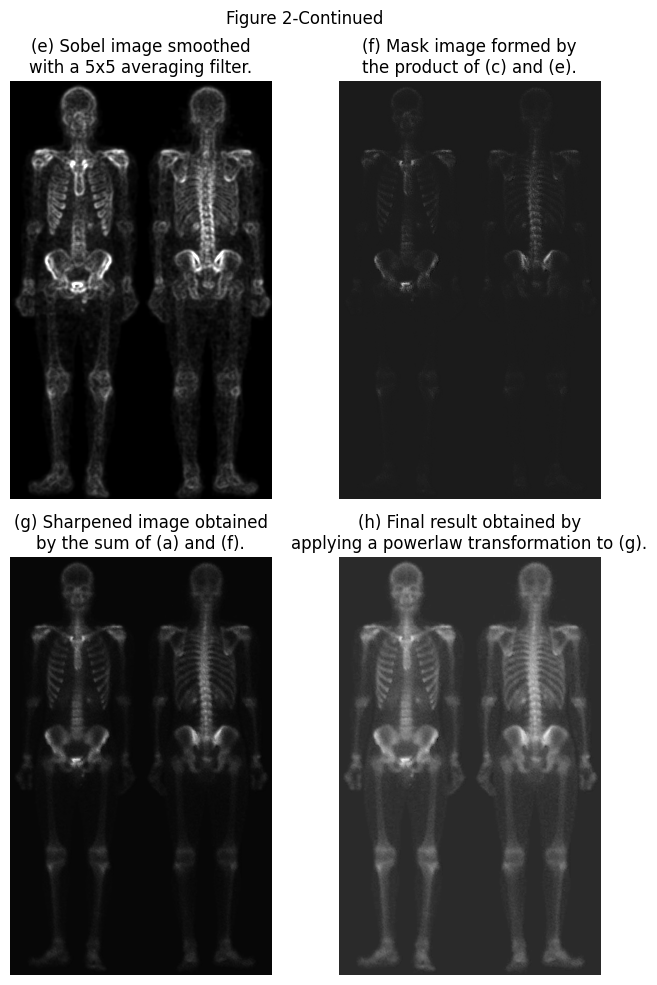

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(7, 10))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off")
ax[0, 0].imshow(g3, cmap="gray", vmin=0, vmax=255), ax[0, 1].imshow(g4, cmap="gray", vmin=0, vmax=255)
ax[1, 0].imshow(g5, cmap="gray", vmin=0, vmax=255), ax[1, 1].imshow(myGammaTransformation(1, 0.5, g5), cmap="gray", vmin=0, vmax=255)
ax[0, 0].set_title("(e) Sobel image smoothed\nwith a 5x5 averaging filter."), ax[0, 1].set_title("(f) Mask image formed by\nthe product of (c) and (e).")
ax[1, 0].set_title("(g) Sharpened image obtained\nby the sum of (a) and (f)."), ax[1, 1].set_title("(h) Final result obtained by\napplying a powerlaw transformation to (g).")
fig.suptitle("Figure 2-Continued")
fig.tight_layout()
plt.show()

Figure2(e) şıkkında da (b),(c) ve (d) şıklarındaki adımlar uygulanmıştır. Figure2(f) şıkkındaki görsel için Figure1(f) şıkkında, zaman domaininde keskinleştirilmiş ve bulanıklaştırılmış iki görsel çarpılarak elde edilmiştir. Fakat, burada frekans domaininde aynı işlemi gerçekleştirebilmek amacıyla konvolüsyon alınmalıdır. Boyutlarının büyük olması sebebiyle konvolüsyon işlemi N^4 süre almakta ve bu işlem çok uzun sürmektedir. Farklı fonksiyonlar kullanılarak bu süre kısaltılmaya çalışılsa da hatalı sonuçlar çıkmış ve zaman domaininde bulunan görsel frekans domainin de elde edilememiştir. Bu nedenle, Figure2(c) ve Figure2(e) şıkları zaman domaininde çarpılarak Figure2(f) şıkkı elde edilmiştir. Figure2(g) şıkkı, orijinal görüntü ile (f) şıkkında elde edilen görsel toplanarak bulunmuştur. Bu görselin gamma transformu uygulanması sonucunda da Figure2(h) şıkkındaki görsel ortaya çıkmıştır. Figure1(h) ve Figure2(h) şıkkındaki görseller incelendiğinde Figure2'deki görselin Figure1'e göre daha soluk olduğu gözlemlenmiştir.